In [2]:
import numpy as np
import gym
import torch
import os
import pickle


In [41]:

with open('/home/hirobuchi.ryota/rl_lab/machina/data/expert_epis/HopperPyBulletEnv-v0_max.pkl', 'rb') as f:
    expert_epis = pickle.load(f)

epis num:100
one_iteration: 1000step 15obs 3act


In [47]:
expert_epis[5]["obs"].shape



(1000, 15)

In [147]:
"""
An example of Behavioral Cloning.modifi
"""
import numpy as np
import gym
import os
import pickle


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from machina import loss_functional as lf

from machina.pols import GaussianPol, CategoricalPol, MultiCategoricalPol, DeterministicActionNoisePol
from machina.algos import behavior_clone
from machina.envs import GymEnv, C2DEnv
from machina.traj import Traj
from machina.traj import epi_functional as ef
from machina.samplers import EpiSampler
from machina import logger
from machina.utils import measure, set_device
from torch.nn.init import kaiming_uniform_, uniform_
from simple_net import PolNet, PolNetLSTM, VNet, DiscrimNet
import numpy as np
import torch
import torch.nn as nn

from machina.pols import BasePol
from machina.pds.gaussian_pd import GaussianPd
from machina.utils import get_device


class GaussianPol_VAE(BasePol):
    """
    Policy with Gaussian distribution.

    Parameters
    ----------
    observation_space : gym.Space
        observation's space
    action_space : gym.Space
        action's space
        This should be gym.spaces.Box
    net : torch.nn.Module
    rnn : bool
    normalize_ac : bool
        If True, the output of network is spreaded for action_space.
        In this situation the output of network is expected to be in -1~1.
    """

    def __init__(self, observation_space, action_space, net, rnn=False,
                 normalize_ac=True):
        BasePol.__init__(self, observation_space, action_space, net, rnn,
                         normalize_ac)
        self.pd = GaussianPd()
        self.to(get_device())

    def forward(self, obs, hs=None, h_masks=None):
        obs = self._check_obs_shape(obs)

        if self.rnn:
            time_seq, batch_size, *_ = obs.shape

            if hs is None:
                if self.hs is None:
                    self.hs = self.net.init_hs(batch_size)
                hs = self.hs

            if h_masks is None:
                h_masks = hs[0].new(time_seq, batch_size, 1).zero_()
            h_masks = h_masks.reshape(time_seq, batch_size, 1)

            mean, log_std, hs = self.net(obs, hs, h_masks)
            self.hs = hs
        else:
            mean, log_std , latent= self.net(obs)
        log_std = log_std.expand_as(mean)
        ac = self.pd.sample(dict(mean=mean, log_std=log_std))
        ac_real = self.convert_ac_for_real(ac.detach().cpu().numpy())
        return ac_real, ac, dict(mean=mean, log_std=log_std, hs=hs, latent= latent)

    def deterministic_ac_real(self, obs, hs=None, h_masks=None):
        """
        action for deployment
        """
        obs = self._check_obs_shape(obs)

        if self.rnn:
            time_seq, batch_size, *_ = obs.shape
            if hs is None:
                if self.hs is None:
                    self.hs = self.net.init_hs(batch_size)
                hs = self.hs

            if h_masks is None:
                h_masks = hs[0].new(time_seq, batch_size, 1).zero_()
            h_masks = h_masks.reshape(time_seq, batch_size, 1)

            mean, log_std, hs = self.net(obs, hs, h_masks)
            self.hs = hs
        else:
            mean, log_std , latent= self.net(obs)
        mean_real = self.convert_ac_for_real(mean.detach().cpu().numpy())
        return mean_real, mean, dict(mean=mean, log_std=log_std, hs=hs, latent=latent)


def mini_weight_init(m):
    if m.__class__.__name__ == 'Linear':
        m.weight.data.copy_(uniform_(m.weight.data, -3e-3, 3e-3))
        m.bias.data.fill_(0)


def weight_init(m):
    if m.__class__.__name__ == 'Linear':
        m.weight.data.copy_(kaiming_uniform_(m.weight.data))
        m.bias.data.fill_(0)

## BC
def log_likelihood(pol, batch):
    obs = batch['obs']
    acs = batch['acs']
    _, _, pd_params = pol(obs)
    llh = pol.pd.llh(acs, pd_params)
    pol_loss = -torch.mean(llh)
    return pol_loss


def vae_loss(pol, batch,add_L1 = True):
    lam = 0.7
    latent_classnum = pol.net.latent_classnum
    obs = batch['obs']
    acs = batch['acs']
    _, _, pd_params = pol(obs) # must be fixed of return num
    llh = pol.pd.llh(acs, pd_params)
    llh_loss = -torch.mean(llh)
    #print( pd_params["latent"])
    log_qy, qy = pd_params["latent"]
    
    kl_tmp = (qy * (log_qy - torch.log(torch.tensor(1.0 / latent_classnum)))).view(-1, pol.net.latent_dim, pol.net.latent_classnum)
    KL = torch.sum(torch.sum(kl_tmp, 2),1)
    
    L_1 =log_qy.mean(dim =1)
    elbo = llh_loss +  KL 
    if add_L1:
        elbo = elbo -lam* L_1

    return elbo, llh_loss, KL



def update_pol(pol, optim_pol, batch):
    
    pol_loss, llh, KL = vae_loss(pol, batch)
    
    optim_pol.zero_grad()
    pol_loss.backward()
    optim_pol.step()
    return pol_loss.detach().cpu().numpy(),llh

def train(expert_traj, pol, optim_pol, seq_length=10, epoch=1):
    pol_losses = []
    llh_losses =[]
    
    iterater = expert_traj.random_batch_rnn(batch_size = 1, seq_length = seq_length, epoch=epoch)
    for batch in iterater:
        pol.net.randomize_latent_code()
        for sa_i in range(seq_length):
            loss_tmp = np.zeros((seq_length,2))
            sa = dict()
            sa["obs"] = batch["obs"][sa_i].view(batch["obs"].size()[2:])
            sa["acs"] = batch["acs"][sa_i].view(batch["acs"].size()[2:])

            pol_loss,llh = update_pol(pol, optim_pol, sa)
            loss_tmp[sa_i,0]= pol_loss
            loss_tmp[sa_i,1]= llh
        loss_mean = loss_tmp.mean(axis = 0)
        pol_losses.append(float(loss_mean[0]))
        llh_losses.append(float(loss_mean[1]))
    return dict(PolLoss=pol_losses, llh_loss = llh_losses)

def train_batch(expert_traj, pol, optim_pol, seq_length=32, epoch=100 ):
    pol_losses = []
    llh_losses =[]
    
    iterater = expert_traj.random_batch_rnn(batch_size = 1, seq_length = seq_length, epoch=epoch)
    for ep, batch in enumerate(iterater):
        pol.net.randomize_latent_code()
        first_sa = True
        for sa_i in range(seq_length):
            loss_tmp = np.zeros((seq_length,2))
            sa = dict()
            sa["obs"] = batch["obs"][sa_i].view(batch["obs"].size()[2:])
            sa["acs"] = batch["acs"][sa_i].view(batch["acs"].size()[2:])

            pol_loss, llh, KL = vae_loss(pol,sa)
            if first_sa == True:
                pol_loss_sum = pol_loss
                first_sa = False
            else:
                pol_loss_sum += pol_loss 
            loss_tmp[sa_i,0]= pol_loss
            loss_tmp[sa_i,1]= llh
        #update
        optim_pol.zero_grad()
        pol_loss_sum.backward()
        optim_pol.step()
        #decay tau
        
        
        loss_mean = loss_tmp.mean(axis = 0)
        pol_losses.append(float(loss_mean[0]))
        llh_losses.append(float(loss_mean[1]))
    return dict(PolLoss=pol_losses, llh_loss = llh_losses)


def test(expert_traj, pol):
    pol.eval()
    pol_loss_mean= 0
    counter =0
    iterater = expert_traj.full_batch(epoch=1)
    for batch in iterater:
        with torch.no_grad():
            for sa_i in range(len(batch["obs"])):
                sa = dict()
                sa["obs"] = batch["obs"][sa_i]
                sa["acs"] = batch["acs"][sa_i]
                pol_loss = lf.log_likelihood(pol, sa)
                counter +=1
                pol_loss_mean += pol_loss
    pol_loss_mean = pol_loss_mean/counter
    return dict(Testllh_Loss=[float(pol_loss_mean.detach().cpu().numpy())])

def mini_weight_init(m):
    if m.__class__.__name__ == 'Linear':
        m.weight.data.copy_(uniform_(m.weight.data, -3e-3, 3e-3))
        m.bias.data.fill_(0)


def weight_init(m):
    if m.__class__.__name__ == 'Linear':
        m.weight.data.copy_(kaiming_uniform_(m.weight.data))
        m.bias.data.fill_(0)

def sample_gumbel(shape, eps=1e-20):
    U = torch.Tensor(shape).uniform_(0,1)#.cuda()
    return -(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        y = (y_hard - y).detach() + y
    return y
def get_onehot(index_array, class_num):
    assert isinstance(index_array,torch.Tensor), "index_array must be torch.Tensor"
    assert len(index_array.size()) == 1, "get_onehot index must be 1dim array"
    return torch.eye(class_num)[index_array].view(1,-1)

    
    
class VAEPolNet(nn.Module):
    def __init__(self, observation_space, action_space, h1=64, h2=64, deterministic=False):
        super(VAEPolNet, self).__init__()

        self.deterministic = deterministic

        if isinstance(action_space, gym.spaces.Box):
            self.discrete = False
        else:
            self.discrete = True
            if isinstance(action_space, gym.spaces.MultiDiscrete):
                self.multi = True
            else:
                self.multi = False

        self.state_dim = observation_space.shape[0]
        #self.action_dim = action_space.shape[0]
        self.latent_classnum = 3
        self.latent_dim = 1
        self.randomize_latent_code()
        self.update_latent_code = True

        tau0 = 1.0
        self.tau = 5.0#torch.autograd.Variable(torch.tensor(tau0))
                

        self.fce1 = nn.Linear(self.state_dim + self.latent_classnum , 64)
        self.fce2 = nn.Linear(64, self.latent_classnum* self.latent_dim)
        #self.fce3 = nn.Linear
        self.fcd1 = nn.Linear(self.latent_classnum * self.latent_dim + self.state_dim, h1)
        self.fcd2 = nn.Linear(h1,h2)
        if not self.discrete:
            self.mean_layer = nn.Linear(h2, action_space.shape[0])
            if not self.deterministic:
                self.log_std_param = nn.Parameter(
                    torch.randn(action_space.shape[0])*1e-10 - 1)
            self.mean_layer.apply(mini_weight_init)
        else:
            if self.multi:
                self.output_layers = nn.ModuleList(
                    [nn.Linear(h2, vec) for vec in action_space.nvec])
                list(map(lambda x: x.apply(mini_weight_init), self.output_layers))
            else:
                self.output_layer = nn.Linear(h2, action_space.n)
                self.output_layer.apply(mini_weight_init)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(1)
    
    def set_tau(self, tau):
        self.tau = tau

    def sample_latent_code(self):
        self.latent_code = torch.eye(self.latent_classnum)[torch.randint(low = 0, high= self.latent_classnum ,size =  (self.latent_dim,))].view(1,-1)

    def encode(self, x):
        input_and_latent_code  = torch.cat([x, self.latent_code],dim = 1)
        he1 = nn.ReLU()(self.fce1(input_and_latent_code))
        #he2 = self.relu(self.fce2(he1))
        he2 = self.fce2(he1)
        logits_y = he2.view(-1,self.latent_classnum )
        qy = self.softmax(logits_y)# each class likelyhood
        log_qy = torch.log(qy + 1e-20)
        return logits_y, log_qy, qy

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z, x):
        # sample and reshape back (shape=(batch_size,N,K))
        # set hard=True for ST Gumbel-Softmax
        assert len(x.size()) ==2, "x can't be batch"
        ge = gumbel_softmax(z, self.tau, hard=False).view(-1, self.latent_dim, self.latent_classnum)
        
        concat_input = torch.cat([x,ge.view(1,self.latent_dim * self.latent_classnum)], dim = 1)
        hd1 = nn.ReLU()(self.fcd1(concat_input))
        hd2 = nn.ReLU()(self.fcd2(hd1))
        #hd3 = self.fcd3(hd2)
        return hd2, ge


    def get_latent_code(self):
        # return numpy label array
        return self.latent_code.view(self.latent_dim, self.latent_classnum).argmax(dim = -1).numpy()        
    def randomize_latent_code(self):
        self.latent_code = torch.eye(self.latent_classnum)[torch.randint(low = 0, high= self.latent_classnum ,size =  (self.latent_dim,))].view(1,-1)


    def forward(self, ob):
        logits_y, log_qy, qy = self.encode(ob)
        
        h , ge = self.decode(logits_y,ob)
        if self.update_latent_code:
            assert ge.size()[0]== 1, "this script can't deal with batch"
            self.latent_code = get_onehot(ge.argmax(dim = -1).view(-1), self.latent_classnum)

        if not self.discrete:
            mean = torch.tanh(self.mean_layer(h))
            if not self.deterministic:
                log_std = self.log_std_param.expand_as(mean)
                return mean, log_std, [log_qy, qy]
            else:
                return mean, [log_qy, qy]
        else:
            if self.multi:
                return torch.cat([torch.softmax(ol(h), dim=-1).unsqueeze(-2) for ol in self.output_layers], dim=-2), [log_qy, qy]
            else:
                return torch.softmax(self.output_layer(h), dim=-1), [log_qy, qy]



      

In [148]:
if __name__ == "__main__":
    #device_name = "cuda"
    model_dir_path = "./garbage/models/vae/"
    model_name = "vae_with_decay_train_batch_l1loss_1"
    #device = torch.device(device_name)
    #set_device(device)
    env_name = "HopperPyBulletEnv-v0"
    env = GymEnv(env_name)
    env.env.seed(42)

    observation_space = env.observation_space
    action_space = env.action_space

    from machina.traj import Traj
    from machina.traj import epi_functional as ef
    

    with open('/home/hirobuchi.ryota/rl_lab/machina/data/expert_epis/HopperPyBulletEnv-v0_max.pkl', 'rb') as f:
        expert_epis = pickle.load(f)
    train_epis, test_epis = ef.train_test_split(
        expert_epis, train_size=0.7)
    train_traj = Traj()
    train_traj.add_epis(train_epis)
    train_traj.register_epis()
    test_traj = Traj()
    test_traj.add_epis(test_epis)
    test_traj.register_epis()
    expert_rewards = [np.sum(epi['rews']) for epi in expert_epis]
    expert_mean_rew = np.mean(expert_rewards)
    pol_net = VAEPolNet(observation_space, action_space)
    if isinstance(action_space, gym.spaces.Box):
        pol = GaussianPol_VAE(observation_space, action_space, pol_net)
    elif isinstance(action_space, gym.spaces.Discrete):
        pol = CategoricalPol(observation_space, action_space, pol_net)
    elif isinstance(action_space, gym.spaces.MultiDiscrete):
        pol = MultiCategoricalPol(observation_space, action_space, pol_net)
    else:
        raise ValueError('Only Box, Discrete, and MultiDiscrete are supported')
    optim_pol = torch.optim.Adam(pol_net.parameters())
    epochs = 1000
    seq_length = 32
    for i in range(epochs):
        result_dict =train_batch(
                train_traj, pol, optim_pol,
                seq_length=seq_length, epoch=2
            )
        pol.net.set_tau(max(0.1,np.exp(-3e-3 * i)*5.0))
        
        if i%100 ==0:
            print(pol.net.tau)
            test_result_dict =test(test_traj, pol)

            print(f"PolLoss:",np.array(result_dict["PolLoss"]).mean(),
                  "llh_Loss:",np.array(result_dict[r"llh_loss"]).mean(),"testllh_loss:",test_result_dict["Testllh_Loss"]) 
    
    torch.save(pol.state_dict(), model_dir_path + model_name +f'epoch{epochs}_seq_length{seq_length}.pkl')

WalkerBase::__init__
2019-12-08 22:57:23.931805 JST | observation space: Box(15,)
2019-12-08 22:57:23.932540 JST | action space: Box(3,)
5.0
PolLoss: 0.023340758867561817 llh_Loss: -0.0010278383269906044 testllh_loss: [1.3988311290740967]
3.7040911034085893
PolLoss: 0.006961373146623373 llh_Loss: -0.017073663882911205 testllh_loss: [-0.3266916275024414]
2.744058180470132
PolLoss: -0.012529893778264523 llh_Loss: -0.03656350262463093 testllh_loss: [-0.9674285054206848]
2.0328482987029957
PolLoss: -0.032649580389261246 llh_Loss: -0.056684788316488266 testllh_loss: [-1.5392065048217773]
1.5059710595610107
PolLoss: -0.04706384427845478 llh_Loss: -0.07110541313886642 testllh_loss: [-2.004169225692749]
1.115650800742149
PolLoss: -0.05873962491750717 llh_Loss: -0.0827740877866745 testllh_loss: [-2.420464515686035]
0.8264944411079327
PolLoss: -0.0683678463101387 llh_Loss: -0.09240838885307312 testllh_loss: [-2.773127317428589]
0.6122821412649095
PolLoss: -0.08306248113512993 llh_Loss: -0.107124

In [107]:
if __name__ == "__main__":
    #device_name = "cuda"
    
    #device = torch.device(device_name)
    #set_device(device)
    env_name = "HopperPyBulletEnv-v0"
    env = GymEnv(env_name)
    env.env.seed(42)
    save_pol = 

    observation_space = env.observation_space
    action_space = env.action_space

    from machina.traj import Traj
    from machina.traj import epi_functional as ef
    

    with open('/home/hirobuchi.ryota/rl_lab/machina/data/expert_epis/HopperPyBulletEnv-v0_max.pkl', 'rb') as f:
        expert_epis = pickle.load(f)
    train_epis, test_epis = ef.train_test_split(
        expert_epis, train_size=0.7)
    train_traj = Traj()
    train_traj.add_epis(train_epis)
    train_traj.register_epis()
    test_traj = Traj()
    test_traj.add_epis(test_epis)
    test_traj.register_epis()
    expert_rewards = [np.sum(epi['rews']) for epi in expert_epis]
    expert_mean_rew = np.mean(expert_rewards)
    pol_net = VAEPolNet(observation_space, action_space)
    if isinstance(action_space, gym.spaces.Box):
        pol = GaussianPol_VAE(observation_space, action_space, pol_net)
    elif isinstance(action_space, gym.spaces.Discrete):
        pol = CategoricalPol(observation_space, action_space, pol_net)
    elif isinstance(action_space, gym.spaces.MultiDiscrete):
        pol = MultiCategoricalPol(observation_space, action_space, pol_net)
    else:
        raise ValueError('Only Box, Discrete, and MultiDiscrete are supported')
    optim_pol = torch.optim.Adam(pol_net.parameters())
    epochs = 30
    for i in range(epochs):
        result_dict =train_batch(
                train_traj, pol, optim_pol,
                seq_length=32, epoch=1
            )
        test_result_dict =test(test_traj, pol)
        print(f"PolLoss:",np.array(result_dict["PolLoss"]).mean(),
              "llh_Loss:",np.array(result_dict[r"llh_loss"]).mean(),"testllh_loss:",test_result_dict["Testllh_Loss"])
    if save_pol:
        

SyntaxError: invalid syntax (<ipython-input-107-7b12df986c16>, line 9)

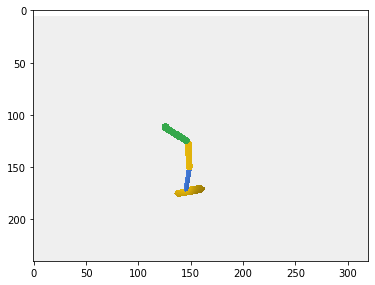

end


"\nprint('step:{} counter:{}'.format(step, counter), end='')\nif step == 999:\n    running = False\n"

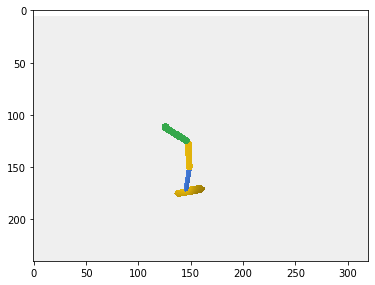

In [146]:
from gym import wrappers
import time
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
render_plt = True
record_video = False
#env = GymEnv(env_name, log_dir="./garbage/vae/video_1000step", record_video=record_video)
env = gym.make(env_name)
#env = wrappers.Monitor(env, "./garbage/vae/video_1000step",force=True)#, video_callable=(lambda ep: ep % 100 == 0))
o = env.reset()
best_path ="/home/hirobuchi.ryota/rl_lab/machina/example/garbage/models/vae/vae_with_decay_train_batchepoch1000_seq_length32.pkl"
#pol2.load_state_dict(torch.load(best_path))
done = False
# Figureを設定
fig = plt.figure(figsize =(6, 6))

# Axesを追加
ax = fig.add_subplot(111)
step_size = 1000
latent_hist = -np.ones(step_size)
running = True
counter = 0

for step in range(step_size): # show 300 frames (=20 sec)
    if done:
        time.sleep(1) # when the boundary　of eposode
        o = env.reset()
        done = False
        print("end")
        break
    z =pol.net.get_latent_code()[0]
    latent_hist[step] = z


    if step%5 ==0 and render_plt:
        ax.imshow(env.render(mode='rgb_array'))
        #ax.imshow(env.render())

        print('step:{} latent:{}'.format(step, z), end='')
        #ax.text(0.5, 0.5, z, size = 40, color = "blue")

        display.clear_output(wait=True)
        display.display(plt.gcf())
    ac_real, ac, a_i = pol.deterministic_ac_real(torch.tensor(o, dtype=torch.float))


    ac_real = ac_real.reshape(pol.action_space.shape)
    next_o, r, done, e_i = env.step(np.array(ac_real))
    o = next_o
"""
print('step:{} counter:{}'.format(step, counter), end='')
if step == 999:
    running = False
"""    
    

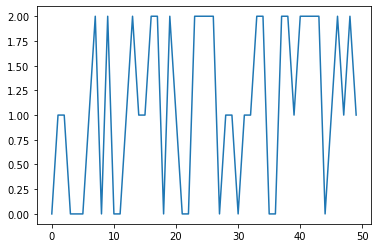

In [26]:
plt.plot(np.arange(0,50),latent_hist[:50])

seq_length=10, epoch=100　x10

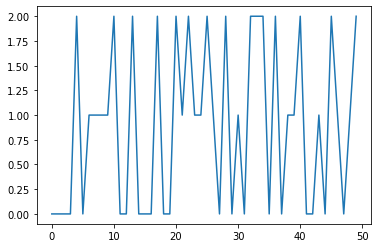

In [62]:
plt.plot(np.arange(0,50),latent_hist[:50])

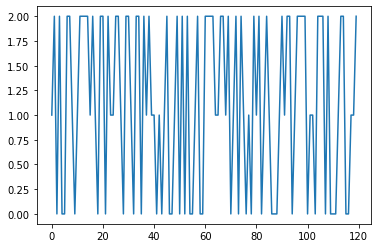

In [33]:
plt.plot(np.arange(0,120),latent_hist[:120])

L1 = 0.0

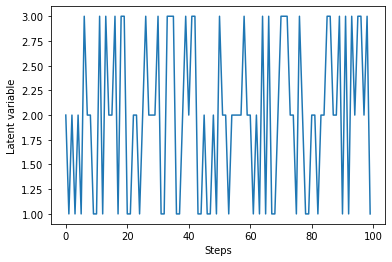

In [97]:
from matplotlib.backends.backend_pdf import PdfPages
length = int(len(latent_hist)  * 0.1)

plt.plot(np.arange(0,length),latent_hist[0:length]+1)
plt.xlabel("Steps")
plt.ylabel("Latent variable")

pp = PdfPages('./garbage/vae_100step_latent.pdf')

# figureをセーブする
pp.savefig()

# pdfファイルをクローズする。
pp.close()


L1 = 0.5

Text(0, 0.5, 'Latent variable')

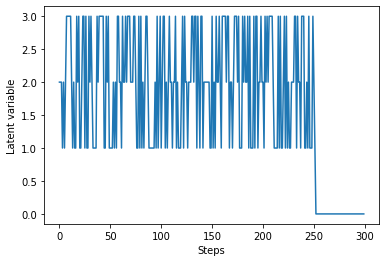

In [132]:
from matplotlib.backends.backend_pdf import PdfPages
length = int(len(latent_hist)  * 0.3)

plt.plot(np.arange(0,length),latent_hist[0:length]+1)
plt.xlabel("Steps")
plt.ylabel("Latent variable")

Text(0, 0.5, 'Latent variable')

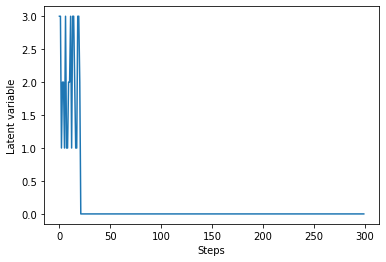

In [145]:
from matplotlib.backends.backend_pdf import PdfPages
length = int(len(latent_hist)  * 0.3)

plt.plot(np.arange(0,length),latent_hist[0:length]+1)
plt.xlabel("Steps")
plt.ylabel("Latent variable")

In [ ]:
other_pol = 

In [66]:
torch.save(pol.state_dict(), os.path.join(
            "/home/hirobuchi.ryota/rl_lab/machina/data", 'vae_models', 'vae_batch20len_100seq_20epoch.pkl'))

In [122]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('BipedalWalker-v2')
env.reset()
for _ in range(1000):
    plt.imshow(env.render(mode='rgb_array'))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    env.step(env.action_space.sample())

AttributeError: module 'gym.envs.box2d' has no attribute 'BipedalWalker'